<a id="section_CART"></a> 
## Workshop Final DS Digital House

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
pd.set_option('display.max_columns', None)
import missingno as msno
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing

%matplotlib inline

## Importando os dados

In [2]:
# importando bases de treino e teste
df_test = pd.read_csv(r"../DataSet/test.csv", low_memory = False)
df_train = pd.read_csv(r"../DataSet/train.csv", low_memory = False)

## Agrupando os datasets para limpar os dados

In [3]:
# # incluindo colunas para sperar os dados da mesma maneira que estavam originalmente
# df_train['test'] = 0
# df_test['test'] = 1

# # incluindo coluna de score com nan nos dados de teste
# df_test['Credit_Score'] = np.nan

In [4]:
# concatenando os datasets ja que eles tem as mesmas colunas

df_total = pd.concat([df_train, df_test], ignore_index = True)
df_orig = df_total.copy()

In [5]:
print('dados de treino: ', df_train.shape)
print('dados de teste: ', df_test.shape)
print('todos os dados agrupados: ', df_total.shape)

dados de treino:  (100000, 28)
dados de teste:  (50000, 27)
todos os dados agrupados:  (150000, 28)


## Colunas do Dataset (ordem alfabética):

* Age - Idade Cliente
* Amount_invested_monthly - Quantidade de dinheiro investido pelo cliente mensalmente
* Annual_Income - renda anual
* Changed_Credit_Limit - Variação percentual de limite do cartão de crédito
* Credit_History_Age - Tempo de histórico de crédito do cliente
* Credit_Mix - mix de crédito do cliente
* Credit_Utilization_Ratio - Taxa de utlização do cartão de crédito
* Customer_ID - ID cliente
* Delay_from_due_date - qtd. de dias de atraso pagamento cartão
* ID - Identificador de entrada
* Interest_Rate - taxa de juros cartão de crédito
* Month - Mês do ano
* Monthly_Balance - Saldo Mensal Cliente
* Monthly_Inhand_Salary - Salario mensal do cliente
* Name - nome do cliente
* Num_Bank_Accounts - quantidade de contas em bancos
* Num_Credit_Card - quantidade de cartões de crédito
* Num_Credit_Inquiries - Quantidade de "cobranças" no cartão
* Num_of_Delayed_Payment - Média de pagamentos atrasado pelo cliente
* Num_of_Loan - Quantidade de empréstimos feitos no banco
* Occupation - Ocupação do cliente
* Outstanding_Debt - restante à ser pago da dívida
* Payment_Behaviour - Comportamento de pagamento cliente
* Payment_of_Min_Amount - Pagamento minimo
* SSN - Social Security Number (CPF no Brasil)
* Total_EMI_per_month - Pagamento fixo em dolares por mes
* Type_of_Loan - tipo de empréstimo feito pelo cliente

* Credit_Score - Target, Pontuação de uso de crédito
* test - coluna utilizada para separar o dataset nos dados de treino e teste

## Checando os principais valores de algumas colunas

In [6]:
colunas = df_total.columns

for coluna in colunas:
    print('Variavel: ', coluna)
    print(20*'-')
    print(df_total[coluna].value_counts(dropna=False))

Variavel:  ID
--------------------
0x234f1    1
0x178ae    1
0x7f80     1
0x15a52    1
0x3e9e     1
          ..
0xb80e     1
0xf5ba     1
0x22c56    1
0x1d7b9    1
0x1f214    1
Name: ID, Length: 150000, dtype: int64
Variavel:  Customer_ID
--------------------
CUS_0x3f47    12
CUS_0x1dac    12
CUS_0x3313    12
CUS_0x321c    12
CUS_0x5a5e    12
              ..
CUS_0x27ad    12
CUS_0xb6bc    12
CUS_0xa12     12
CUS_0x66c7    12
CUS_0xa3db    12
Name: Customer_ID, Length: 12500, dtype: int64
Variavel:  Month
--------------------
April        12500
March        12500
July         12500
November     12500
September    12500
January      12500
August       12500
May          12500
December     12500
February     12500
June         12500
October      12500
Name: Month, dtype: int64
Variavel:  Name
--------------------
NaN                  15000
Stevex                  66
Langep                  65
Jessicad                59
Raymondr                58
                     ...  
Paul Sv       

### Observações

1. Colunas numéricas com "_" ok
    * Age,
    * Annual_Income,
    * Monthly_Inhand_Salary,
    * Num_Bank_Accounts,
    * Num_Credit_Card,
    * Interest_Rate
    * Num_of_Loan
    * Delay_from_due_date
    * Num_of_Delayed_Payment
    * Changed_Credit_Limit
    * Num_Credit_Inquiries
    * Outstanding_Debt
    * Credit_Utilization_Ratio
    * Total_EMI_per_month
    * Amount_invested_monthly
    * Monthly_Balance
2. SSN #F%$D@*&8 ok
3. Occupation _______ ok
4. Type_of_Loan - transformar em lista e indexar
5. Changed_Credit_Limit "_" -> NaN ok
6. Credit_Mix "_" -> NaN ok
7. Credit_History_Age Transformar em qtd. Meses
8. Payment_of_Min_Amount "NM" -> NaN ok
9. Payment_Behaviour "!@9#%8" -> NaN e transformar dado ok

## ajustando os campos númericos que estão definidos como string por terem underlines em alguns registros

In [7]:
# Campos númericos que estão como string - retirar underline dos numeros

colunas_ul = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
              'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
for row in colunas_ul:
    df_total[row] = df_total[row].str.replace(r'_+', '')

<ipython-input-7-307ac66e0f28>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_total[row] = df_total[row].str.replace(r'_+', '')


## Data Wrangling

In [8]:
# Removendo coluna ID, completamente inútil para a análise
df_total.drop(['ID'], axis = 1, inplace = True)

# removendo caracter estranho do SSN
df_total['SSN'].replace('#F%$D@*&8', np.NaN, inplace=True)

# removendo os underlines e colocando NaN na coluna Occupation
df_total['Occupation'].replace('_______', np.NaN, inplace=True)

df_total['Changed_Credit_Limit'].replace(['_', ''], np.NaN, inplace=True)

df_total['Credit_Mix'].replace('_', np.NaN, inplace=True)

df_total['Payment_of_Min_Amount'].replace('NM', np.NaN, inplace=True)

df_total['Payment_Behaviour'].replace('!@9#%8', np.NaN, inplace=True)

In [9]:
# convertendo Credit_History_Age em quantidade de meses
def converter_mes(x):
    if pd.notnull(x):
        ano = int(x.split(' ')[0])
        mes = int(x.split(' ')[3])
        return (ano*12)+mes
    else:
        return x

df_total['Credit_History_age'] = df_total['Credit_History_Age'].apply(lambda x: converter_mes(x)).astype(float)

In [10]:
df_total['Type_of_Loan_ajustado'] = df_total['Type_of_Loan'].replace("[abc]* and ", " ", regex=True)

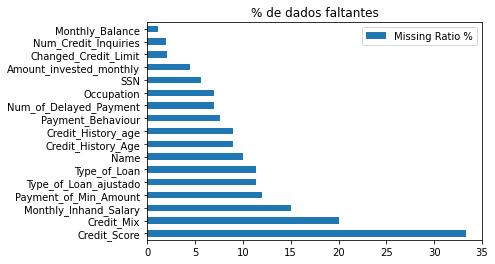

In [11]:
# Esta função define a quantidade % de dados faltantes
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title("% de dados faltantes")
        plt.show()
    else:
        print('No NAs found')
        
plot_nas(df_total)

In [12]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               150000 non-null  object 
 1   Month                     150000 non-null  object 
 2   Name                      135000 non-null  object 
 3   Age                       150000 non-null  object 
 4   SSN                       141600 non-null  object 
 5   Occupation                139500 non-null  object 
 6   Annual_Income             150000 non-null  object 
 7   Monthly_Inhand_Salary     127500 non-null  float64
 8   Num_Bank_Accounts         150000 non-null  int64  
 9   Num_Credit_Card           150000 non-null  int64  
 10  Interest_Rate             150000 non-null  int64  
 11  Num_of_Loan               150000 non-null  object 
 12  Type_of_Loan              132888 non-null  object 
 13  Delay_from_due_date       150000 non-null  i

In [13]:
#criando dicionario e convertendo os dados

dicionario_conversao = {
    'Age': int,
    'Num_Bank_Accounts': int,
    'Num_Credit_Card': int,
    'Num_of_Loan': int,
    'Num_of_Delayed_Payment': int,
    'Annual_Income' : float,
    'Monthly_Inhand_Salary' : float,
    'Interest_Rate' : float,
    'Delay_from_due_date' : float,
    'Changed_Credit_Limit' : float,
    'Num_Credit_Inquiries' : float,
    'Outstanding_Debt' : float,
    'Credit_Utilization_Ratio' : float,
    'Changed_Credit_Limit' : float,
    'Amount_invested_monthly' : float,
    'Total_EMI_per_month' : float,
    'Num_of_Delayed_Payment' : float,
    'Monthly_Balance' : float,
    # 'ID' : object,
    'Customer_ID' : object,
    'Name' : object,
    'Month' : object,
    'SSN' : object,
    'Type_of_Loan' : object,
    'Occupation' : object,
    'Credit_Mix' : object,
    'Payment_of_Min_Amount' : object,
    'Payment_Behaviour' : object
    # 'test' : object
    }
# aplicando as type para variaveis

df_total = df_total.astype(dicionario_conversao)

In [14]:
df_total.head()

,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_age,Type_of_Loan_ajustado
0,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,11.27,4.0,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,265.0,"Auto Loan, Credit-Builder Loan, Personal Loan,..."
1,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1.0,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good,NaN,"Auto Loan, Credit-Builder Loan, Personal Loan,..."
2,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good,267.0,"Auto Loan, Credit-Builder Loan, Personal Loan,..."
3,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5.0,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,268.0,"Auto Loan, Credit-Builder Loan, Personal Loan,..."
4,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6.0,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,269.0,"Auto Loan, Credit-Builder Loan, Personal Loan,..."


### Data cleaning - Age

 * Limitando a idade dos clientes de 0 a 100

In [15]:
df_total = df_total[(df_total['Age'] <= 100) & (df_total['Age'] >= 0)]

# sns.boxplot(data=df_total, y='Age', x='test')

# print(df_total.Age.describe())

### Concentração por tipo de ocupação

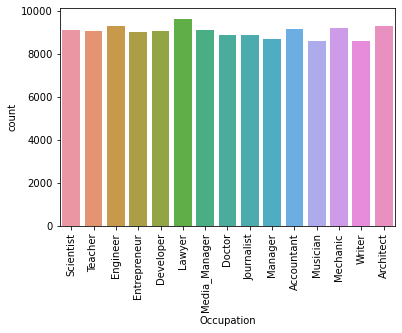

In [16]:
sns.countplot(data=df_total, x = 'Occupation')
plt.xticks(rotation=90)
plt.show()

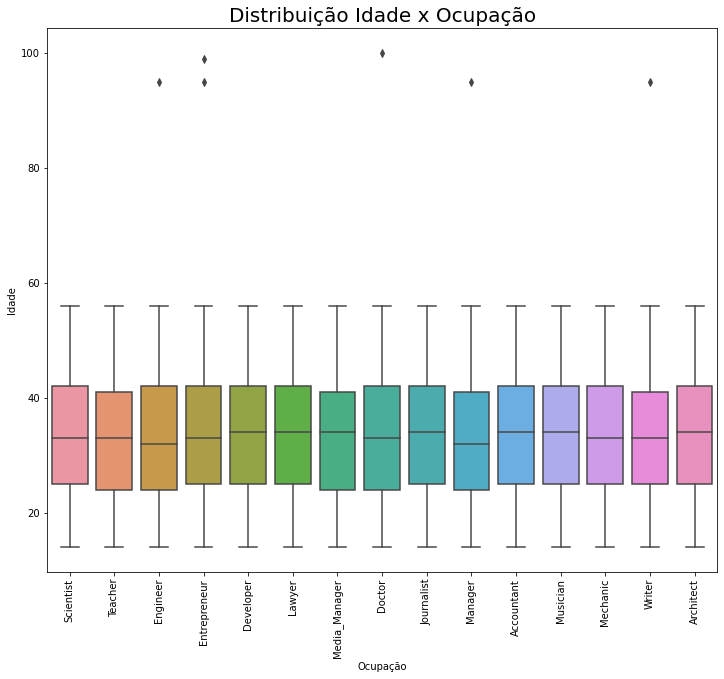

In [17]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Age', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição Idade x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('Idade')
plt.show()

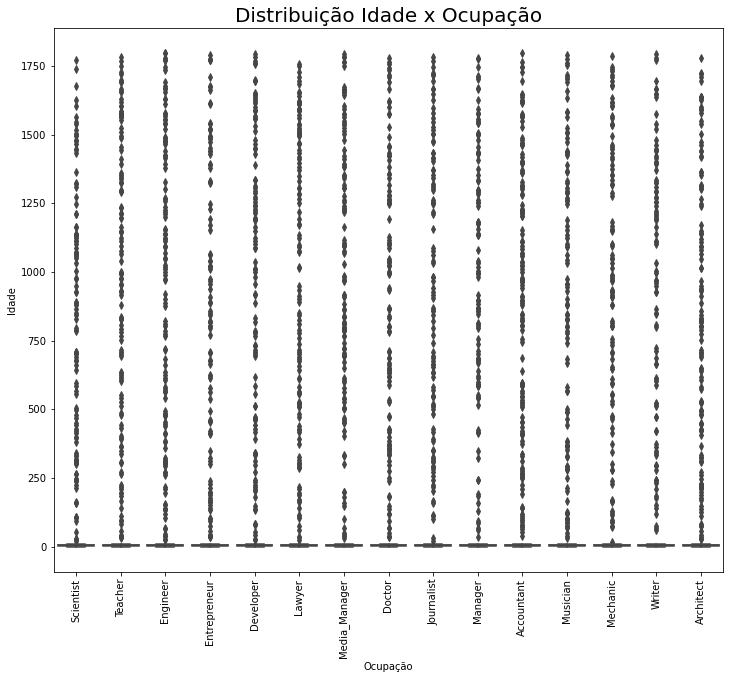

count    145823.000000
mean         17.001961
std         117.075065
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64


In [18]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Num_Bank_Accounts', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição Idade x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('Idade')
plt.show()
print(df_total.Num_Bank_Accounts.describe())

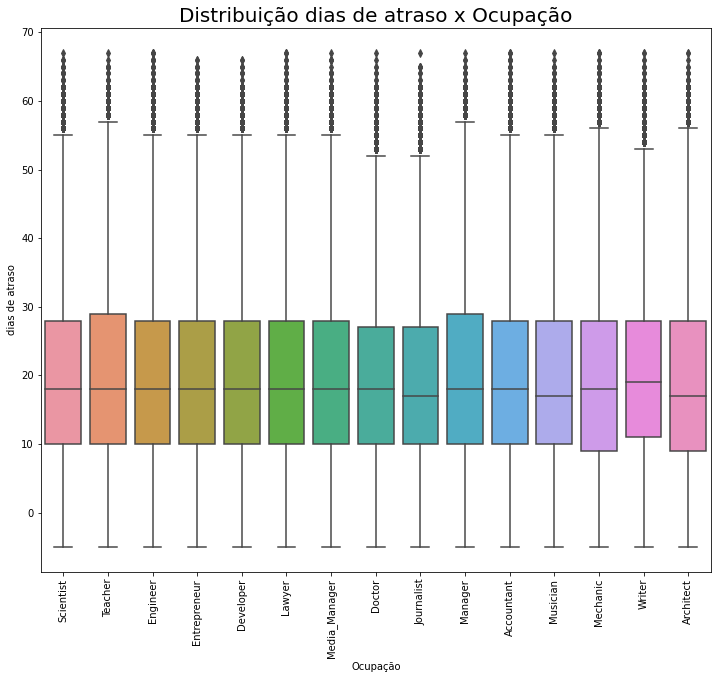

count    145823.000000
mean         21.061534
std          14.861381
min          -5.000000
25%          10.000000
50%          18.000000
75%          28.000000
max          67.000000
Name: Delay_from_due_date, dtype: float64


In [19]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Delay_from_due_date', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição dias de atraso x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('dias de atraso')
plt.show()
print(df_total.Delay_from_due_date.describe())

In [20]:
df_total.columns

Index(['Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'Credit_History_age', 'Type_of_Loan_ajustado'],
      dtype='object')

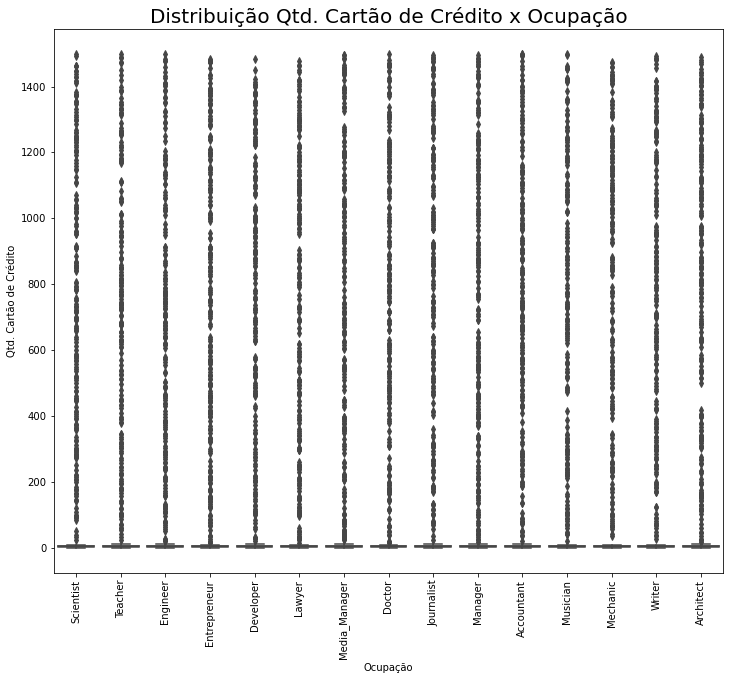

count    145823.000000
mean         22.586848
std         128.930363
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max        1499.000000
Name: Num_Credit_Card, dtype: float64


In [21]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Num_Credit_Card', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição Qtd. Cartão de Crédito x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('Qtd. Cartão de Crédito')
plt.show()
print(df_total.Num_Credit_Card.describe())

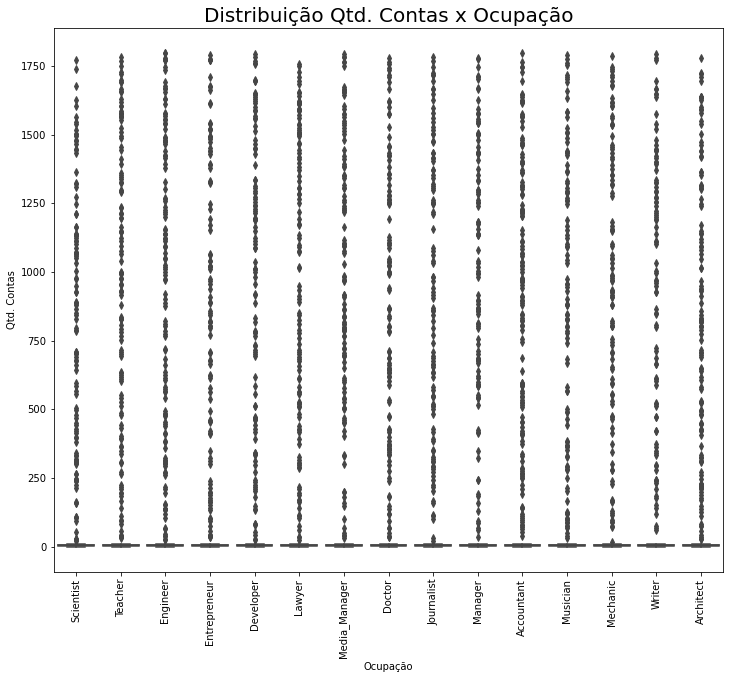

count    145823.000000
mean         17.001961
std         117.075065
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64


In [22]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Num_Bank_Accounts', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição Qtd. Contas x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('Qtd. Contas')
plt.show()
print(df_total.Num_Bank_Accounts.describe())

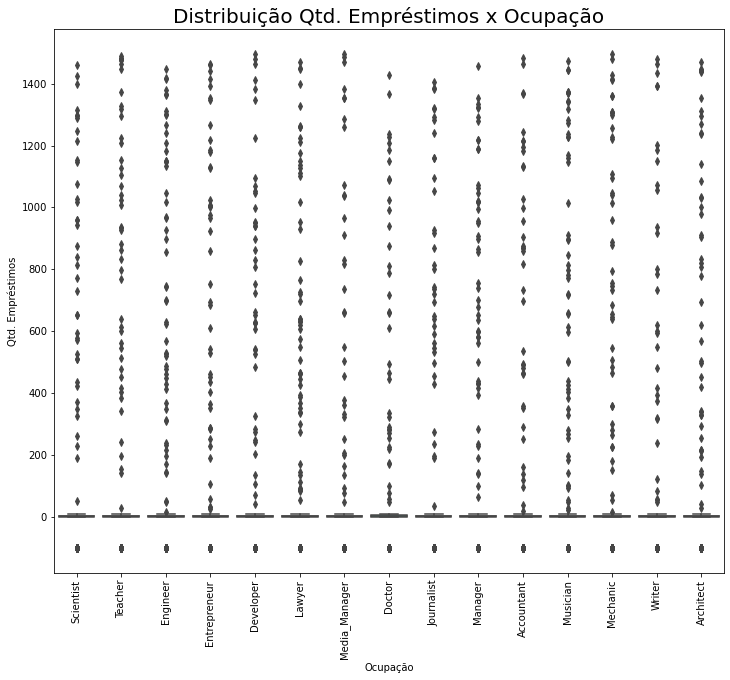

count    145823.000000
mean          3.095719
std          63.560810
min        -100.000000
25%           1.000000
50%           3.000000
75%           5.000000
max        1496.000000
Name: Num_of_Loan, dtype: float64


In [23]:
f, ax = plt.subplots(figsize = (12, 10))
sns.boxplot(data = df_total, y = 'Num_of_Loan', x = 'Occupation')
plt.xticks(rotation = 90)
plt.title('Distribuição Qtd. Empréstimos x Ocupação', size = 20)
plt.xlabel('Ocupação')
plt.ylabel('Qtd. Empréstimos')
plt.show()
print(df_total.Num_of_Loan.describe())

In [24]:
"""
numCols = df_total.select_dtypes([np.number]).columns

for col in numCols:
    fig, ax = plt.subplots(1, 2, figsize = (8,8))
    sns.boxplot(data=df_total, y=col, x = 'Credit_Score', ax=ax[0]) #color = ['#f5190a', '#1e9e19', '#dede16'])
    #sns.scatterplot(data=df_total,x = 'Credit_Score', y = s = 100, y=col, ax=ax[1], color ='#ee1199')
    plt.show()
"""

"\nnumCols = df_total.select_dtypes([np.number]).columns\n\nfor col in numCols:\n    fig, ax = plt.subplots(1, 2, figsize = (8,8))\n    sns.boxplot(data=df_total, y=col, x = 'Credit_Score', ax=ax[0]) #color = ['#f5190a', '#1e9e19', '#dede16'])\n    #sns.scatterplot(data=df_total,x = 'Credit_Score', y = s = 100, y=col, ax=ax[1], color ='#ee1199')\n    plt.show()\n"

<AxesSubplot:>

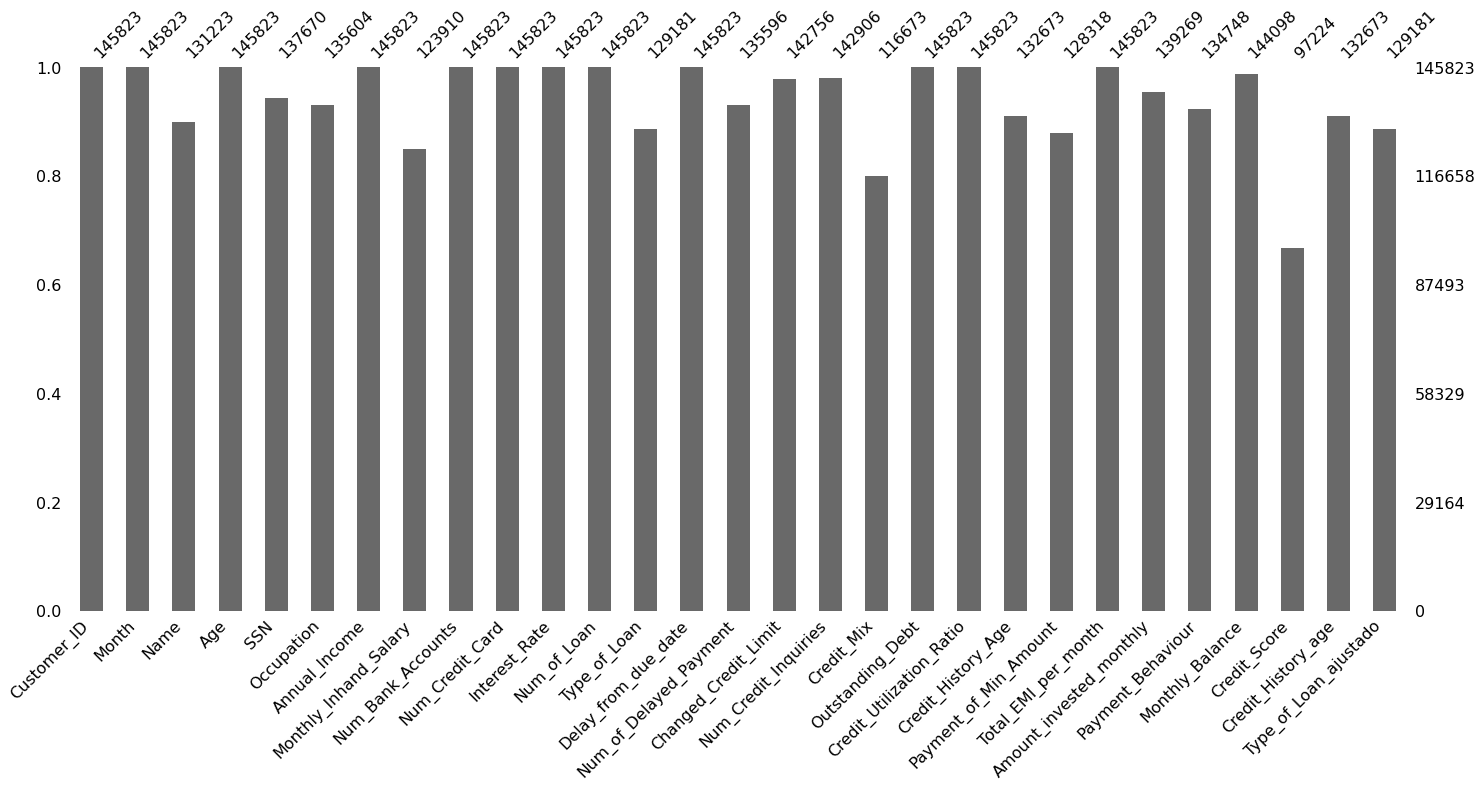

In [25]:
msno.bar(df_total)

c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


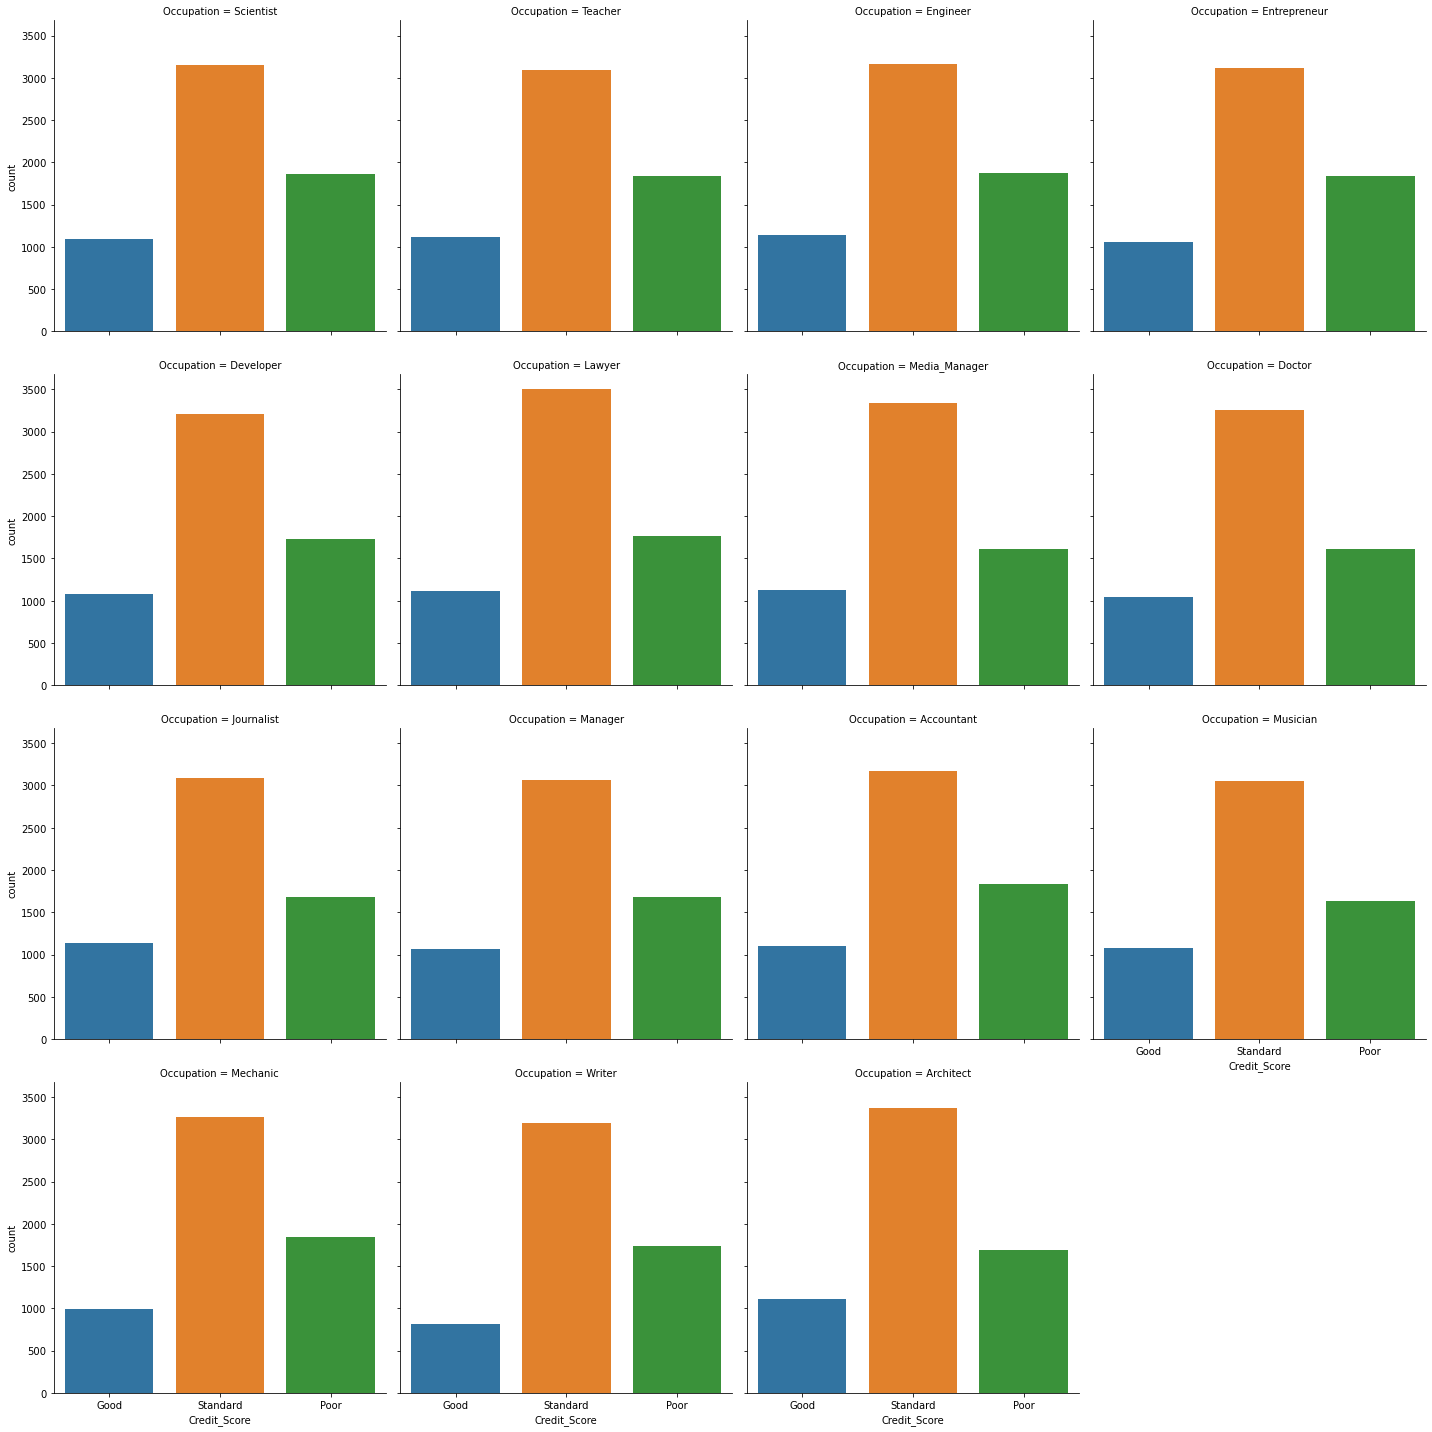

In [26]:
sns.factorplot('Credit_Score', col = 'Occupation', data = df_total, kind = 'count', col_wrap = 4)

c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

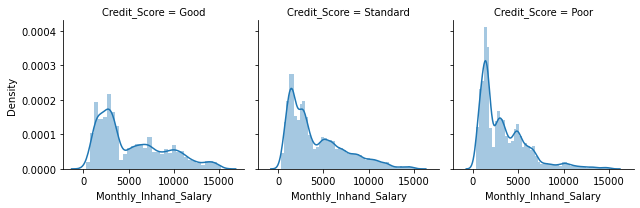

In [27]:
grid = sns.FacetGrid(df_total, col = 'Credit_Score')
grid.map(sns.distplot, 'Monthly_Inhand_Salary')

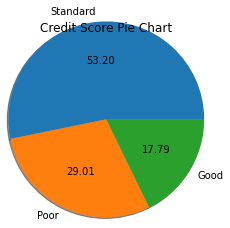

In [28]:
label = df_total.Credit_Score.value_counts().index
label_count = df_total.Credit_Score.value_counts().values
plt.figure(figsize=(3,3))
plt.pie(data=df_total, x=label_count, labels=label, autopct='%.2f', shadow=True, radius=1.5)
plt.title("Credit Score Pie Chart")
plt.show()

In [29]:
#plot(df_total,'Occupation','Credit_Score')

In [30]:
#plot(df_total,'Age','Credit_Score')

<AxesSubplot:>

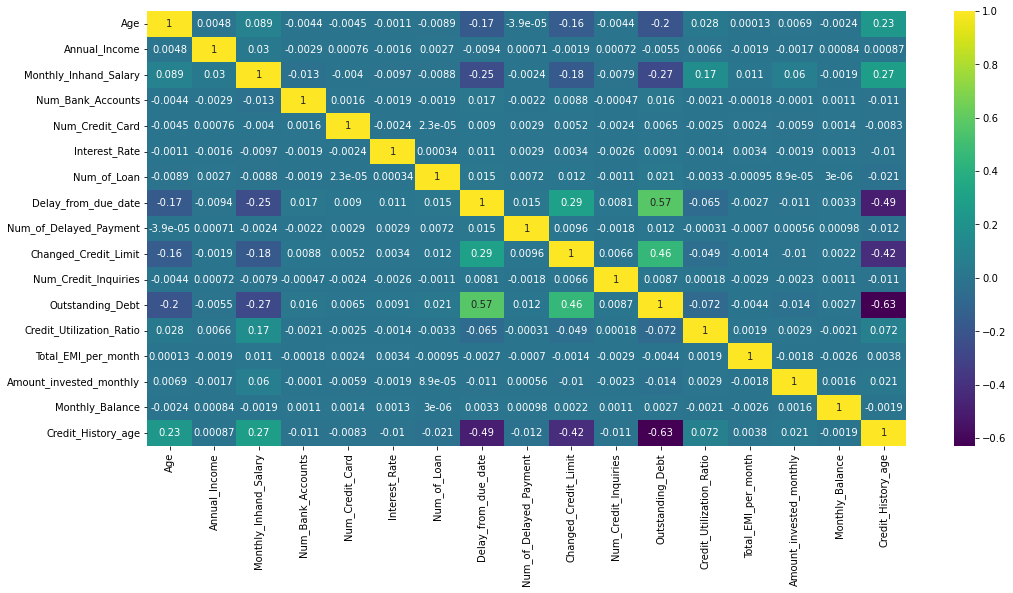

In [31]:
plt.figure(figsize=(17,8))
sns.heatmap(df_total.corr(),annot=True,cmap='viridis')

Text(0.5, 1.0, 'Violin Plot of Payment Behaviour by Age, Separated by Credit Score')

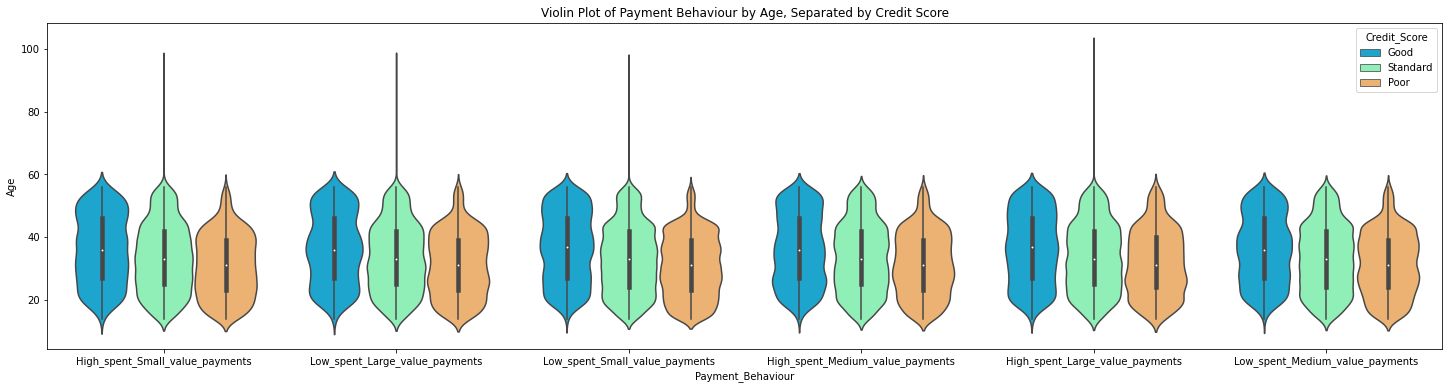

In [32]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Age',data=df_total, hue='Credit_Score', palette='rainbow')
plt.title("Violin Plot of Payment Behaviour by Age, Separated by Credit Score")

Text(0.5, 1.0, 'Violin Plot of Payment Behaviour by Credit Utilization Ratio, Separated by Credit Score')

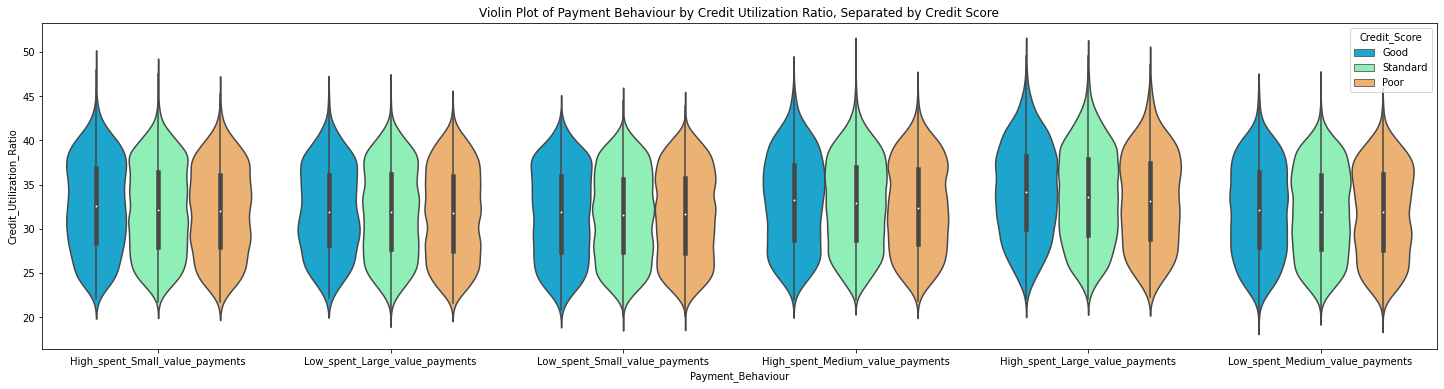

In [33]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Credit_Utilization_Ratio',data=df_total, hue='Credit_Score', palette='rainbow')
plt.title("Violin Plot of Payment Behaviour by Credit Utilization Ratio, Separated by Credit Score")

<Figure size 4248x72 with 0 Axes>

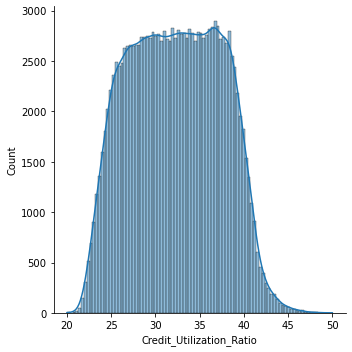

In [34]:
plt.figure(figsize=(59,1))
sns.displot(data=df_total, x="Credit_Utilization_Ratio", kde=True)

<Figure size 12960x432 with 0 Axes>

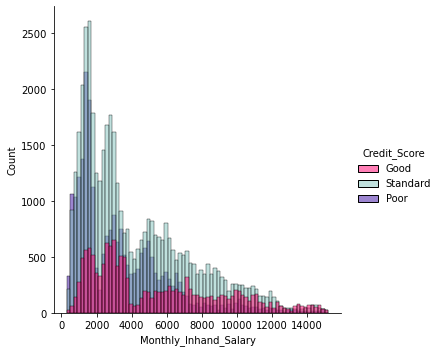

<Figure size 12960x432 with 0 Axes>

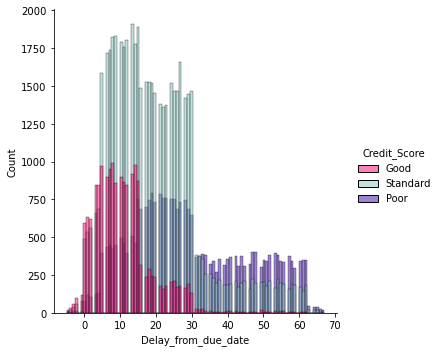

<Figure size 12960x432 with 0 Axes>

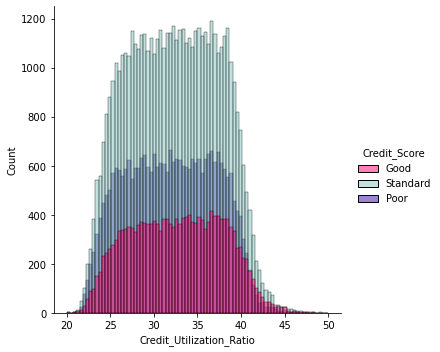

In [35]:
numCols = ['Monthly_Inhand_Salary', 'Delay_from_due_date', 'Credit_Utilization_Ratio']

for col in numCols:
    plt.figure(figsize=(180,6))
    sns.displot(x=col,data=df_total, hue='Credit_Score', palette=["#ff006e", "#83c5be", "#3a0ca3"])
    plt.show()

In [36]:
# convertendo mes para encoding

import datetime

df_total['Month'] = df_total['Month'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)

In [37]:
#DataPrep at its finest pra visualizar tudo, tirar insights, as distribuições, missing data zeros, etc e etc
# create_report(df_total)

In [38]:
print(df_total.shape, df_total.isna().sum())

(145823, 29) Customer_ID                     0
Month                           0
Name                        14600
Age                             0
SSN                          8153
Occupation                  10219
Annual_Income                   0
Monthly_Inhand_Salary       21913
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                16642
Delay_from_due_date             0
Num_of_Delayed_Payment      10227
Changed_Credit_Limit         3067
Num_Credit_Inquiries         2917
Credit_Mix                  29150
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age          13150
Payment_of_Min_Amount       17505
Total_EMI_per_month             0
Amount_invested_monthly      6554
Payment_Behaviour           11075
Monthly_Balance              1725
Credit_Score                48599
Credit_History_age          13150
Type_of_Loan_ajustado       16642
d

In [39]:
df_nonull = df_total.dropna()

In [40]:
# pegando indices

df2 = df_nonull.groupby(["Customer_ID"])["Month"].nlargest(1)

# list comprehension para juntar os índices

indice_final = [i[1] for i in df2.index.values]

# aplicando máscara, pegando somente linha do último mês de cada usuário

df_nonull_uniqueCID = df_total.loc[indice_final]

In [41]:
df_nonull_uniqueCID.shape

(10625, 29)

### Seleção de Features e Feature Importance

In [42]:
#Dropar colunas inúteis (ids etc) e Changed Credit Limit e Credi History Age (vide heatmap)

#ExtraTreeClassifier para usar método feature_importances_

#Logistic regression do statsmodels para usar os testes de hipótese do método summary()

#Técnicas de feature selection da última aula sobre o tema

#Checar variância de cada feature
# pd.options.display.float_format = '{:.6f}'.format
# df_heart.apply(np.var).sort_values(ascending = False)[ : 8]

#Tentar usar o VIF (pode ser interessante ou inútil)

In [54]:
# Pré-processamento para modelos para encontrar melhores features

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

df2 = df_nonull_uniqueCID.copy()
df2 = df2.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Type_of_Loan_ajustado', 'Credit_History_Age'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df2.drop('Credit_Score', axis=1), df2['Credit_Score'], test_size=0.3, random_state=101)

#Pegando variáveis categóricas e numéricas

categorical = list(X_train.select_dtypes(include=['object']).columns)  #Talvez criar no começo pra visualizaçao describe().transpose()
numerical = list(X_train.select_dtypes(include=['int64', 'float64']).columns) #Talvez criar no começo pra visualizaçao describe()

# Dummy Encoder para variáveis categóricas

X_train_categoricals = pd.get_dummies(X_train[categorical], drop_first=True)
X_test_categoricals = pd.get_dummies(X_test[categorical], drop_first=True)

#Scaling para variáveis numéricas

from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

X_train_numericals = pd.DataFrame(stdscaler.fit_transform(X_train[numerical]), columns = numerical, index = X_train_categoricals.index)
X_test_numericals = pd.DataFrame(stdscaler.transform(X_test[numerical]), columns = numerical, index = X_test_categoricals.index)

#Concatenando categóricas encodadas e numéricas escaladas
X_train = pd.concat([X_train_numericals, X_train_categoricals], axis=1)
X_test = pd.concat([X_test_numericals, X_test_categoricals], axis=1)

from sklearn.preprocessing import OrdinalEncoder
ordenc = OrdinalEncoder()
y_train = ordenc.fit_transform(y_train.values.reshape(-1,1))
y_test = ordenc.transform(y_test.values.reshape(-1,1))

In [55]:
# Modelo Statsmodels para teste de hipótese e seleção de features

# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
non_reg_OLS = model.fit()
non_reg_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.776
Model:                            OLS   Adj. R-squared (uncentered):              0.775
Method:                 Least Squares   F-statistic:                              714.0
Date:                Thu, 06 Oct 2022   Prob (F-statistic):                        0.00
Time:                        22:58:05   Log-Likelihood:                         -8257.6
No. Observations:                7437   AIC:                                  1.659e+04
Df Residuals:                    7401   BIC:                                  1.684e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Month                                                  0.0028      0.009      0.331      0.741      -0.014       0.020
Annual_Income                                          0.0062      0.009      0.723      0.470      -0.011       0.023
Monthly_Inhand_Salary                                 -0.0284      0.012     -2.364      0.018      -0.052      -0.005
Interest_Rate                                         -0.0054      0.009     -0.631      0.528      -0.022       0.011
Delay_from_due_date                                    0.0404      0.012      3.349      0.001       0.017       0.064
Num_of_Delayed_Payment                                -0.0153      0.009     -1.794      0.073      -0.032       0.001
Changed_Credit_Limit                                   0.0220      0.010      2.124      0.034       0.002       0.042
Num_Credit_Inquiries                                   0.0103      0.009      1.207      0.227      -0.006       0.027
Outstanding_Debt                                       0.0729      0.014      5.050      0.000       0.045       0.101
Credit_Utilization_Ratio                              -0.0035      0.009     -0.398      0.691      -0.021       0.014
Total_EMI_per_month                                    0.0056      0.009      0.658      0.511      -0.011       0.022
Amount_invested_monthly                               -0.0037      0.009     -0.427      0.670      -0.020       0.013
Monthly_Balance                                        0.0892      0.014      6.431      0.000       0.062       0.116
Credit_History_age                                     0.0267      0.012      2.147      0.032       0.002       0.051
Occupation_Architect                                   0.5465      0.043     12.724      0.000       0.462       0.631
Occupation_Developer                                   0.5942      0.043     13.966      0.000       0.511       0.678
Occupation_Doctor                                      0.6404      0.042     15.235      0.000       0.558       0.723
Occupation_Engineer                                    0.5853      0.043     13.765      0.000       0.502       0.669
Occupation_Entrepreneur                                0.6010      0.043     14.137      0.000       0.518       0.684
Occupation_Journalist                                  0.5611      0.044     12.823      0.000       0.475       0.647
Occupation_Lawyer                                      0.5897      0.041     14.336      0.000       0.509       0.670
Occupation_Manager                                     0.6044      0.043     14.118      0.000       0.520       0.688
Occupatio

In [44]:
#VIF

def calc_vif(data):
    vif_df = pd.DataFrame(columns=['Var', 'VIF'])
    x_var_names = data.columns
    
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop(x_var_names[i])]
        r2 = sm.OLS(y, x).fit().rsquared
        vif = round(1/(1-r2),3)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by='VIF',axis = 0, ascending=False, inplace=False)

calc_vif(X_train)

,Var,VIF
8,Outstanding_Debt,2.860
12,Monthly_Balance,2.637
13,Credit_History_age,2.123
4,Delay_from_due_date,2.001
2,Monthly_Inhand_Salary,1.975
6,Changed_Credit_Limit,1.471
9,Credit_Utilization_Ratio,1.060
11,Amount_invested_monthly,1.011
0,Month,1.005
3,Interest_Rate,1.005


<AxesSubplot:>

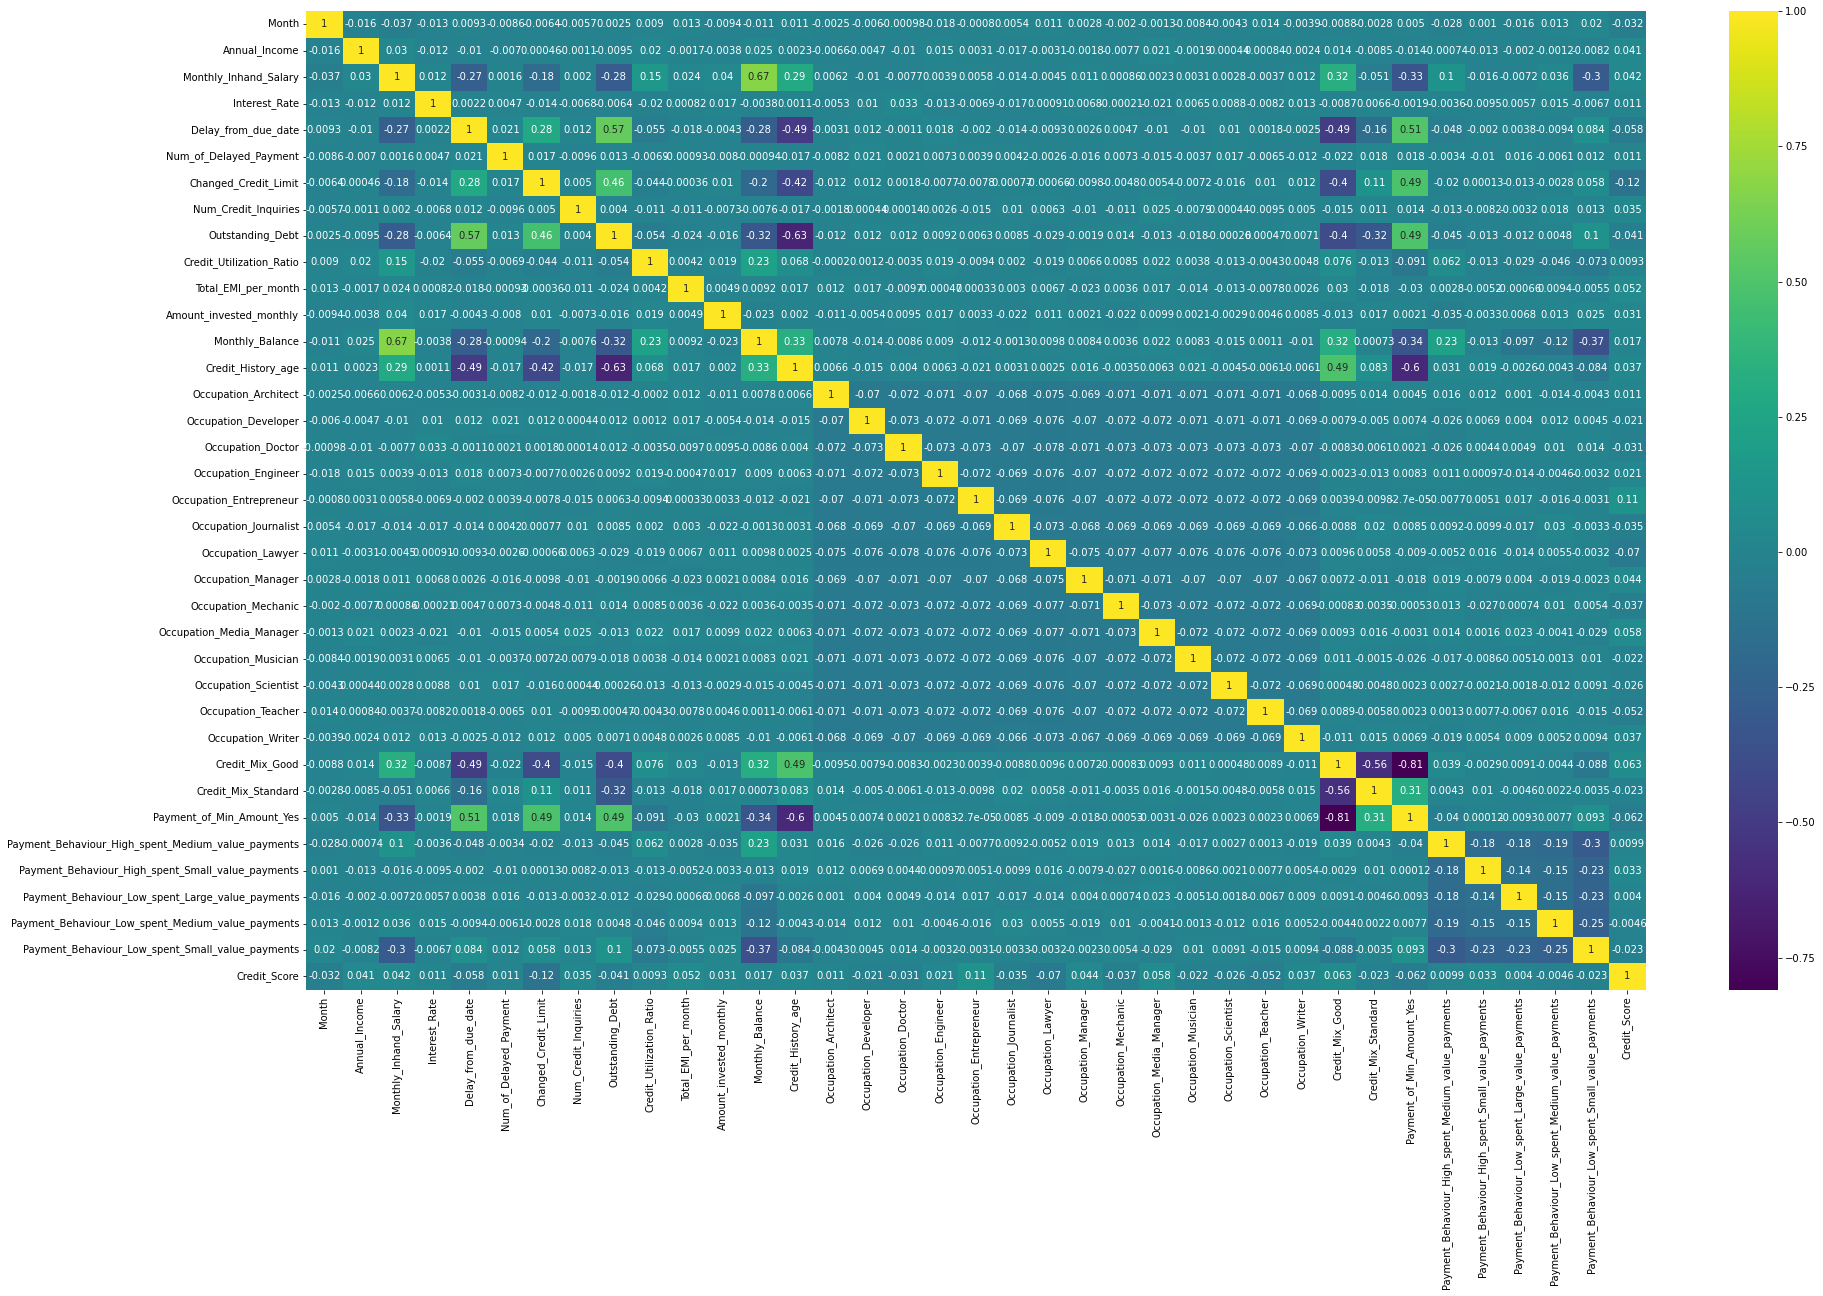

In [45]:
plt.figure(figsize=(30,18))
sns.heatmap(pd.concat([X_train, pd.Series(y_train.ravel(), name = 'Credit_Score')], axis = 1).corr(),annot=True,cmap='viridis')

<AxesSubplot:>

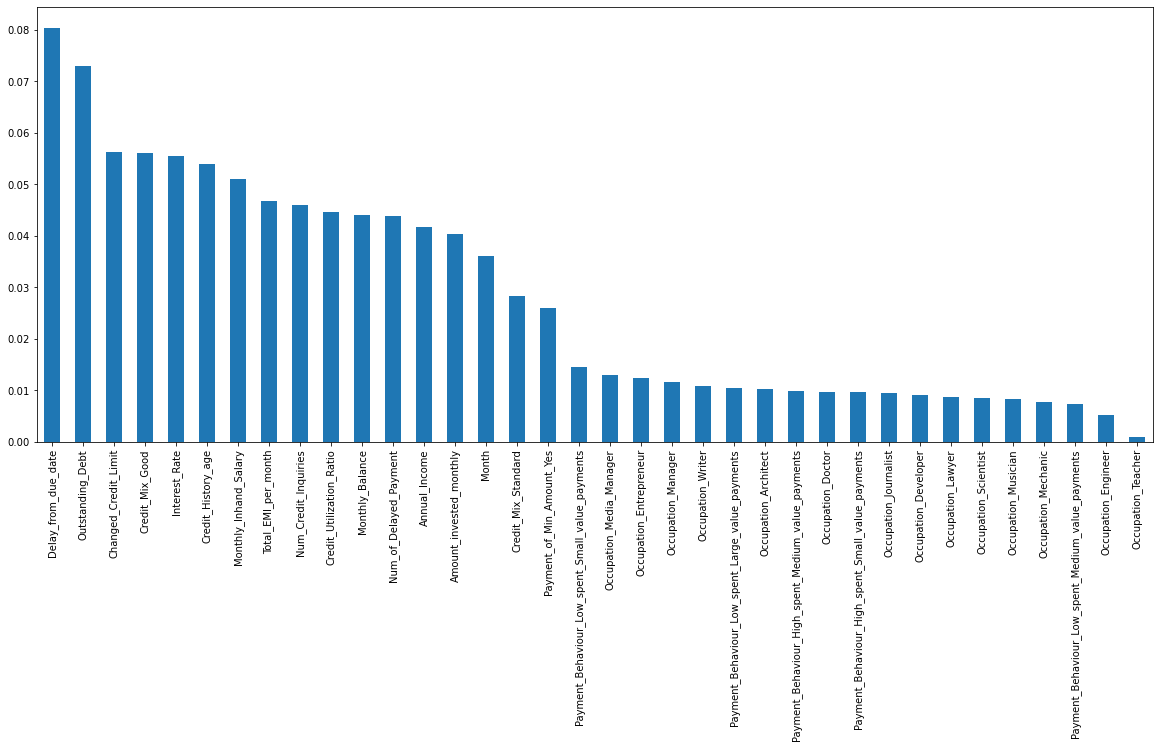

In [46]:
#ExtraTreeClassifier para feature_importances_

from sklearn.tree import ExtraTreeClassifier

xtc = ExtraTreeClassifier()
xtc.fit(X_train, y_train)
feat_importance = pd.Series(xtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20,8))
feat_importance.plot(kind='bar')

### PCA - Visualização e Feature Importance

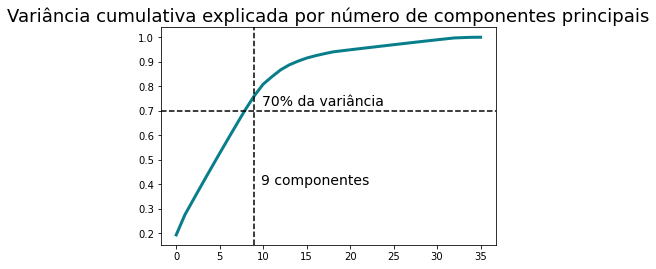

In [47]:
# Visualização da Análise de Componentes Principais (PCA)
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.axhline(0.7, ls='--', color='k')
plt.axvline(9, ls='--', color='k')
plt.text(9.9, 0.72, '70% da variância', fontsize=14)
plt.text(9.8, 0.4, '9 componentes', fontsize=14)
plt.title('Variância cumulativa explicada por número de componentes principais', size=18)
plt.show()

In [48]:
pca.explained_variance_ratio_[:18]

array([0.1937477 , 0.08206063, 0.063651  , 0.06317309, 0.06232321,
       0.06181342, 0.06093896, 0.06039611, 0.05955853, 0.0543313 ,
       0.04650349, 0.03033662, 0.02797291, 0.02048335, 0.01502199,
       0.01279338, 0.0093871 , 0.00813454])

<AxesSubplot:>

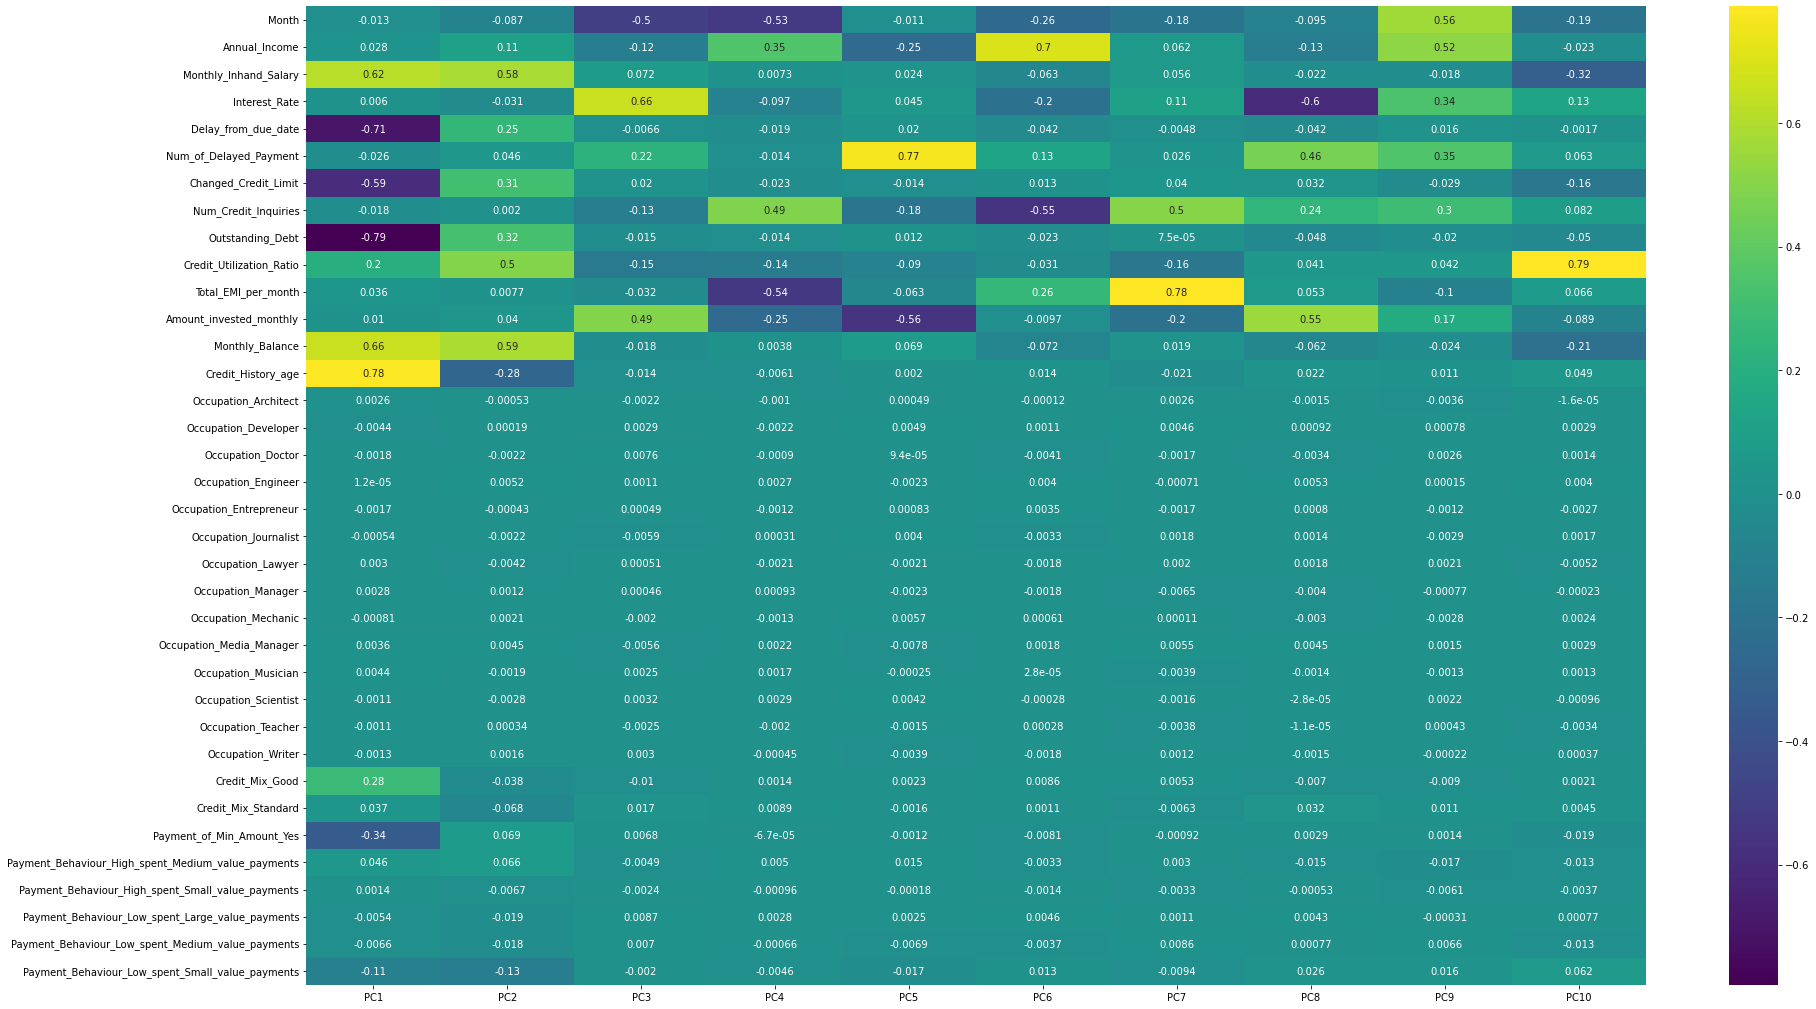

In [49]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

plt.figure(figsize=(30,18))
sns.heatmap(loadings.iloc[:,:10], annot=True, cmap='viridis')

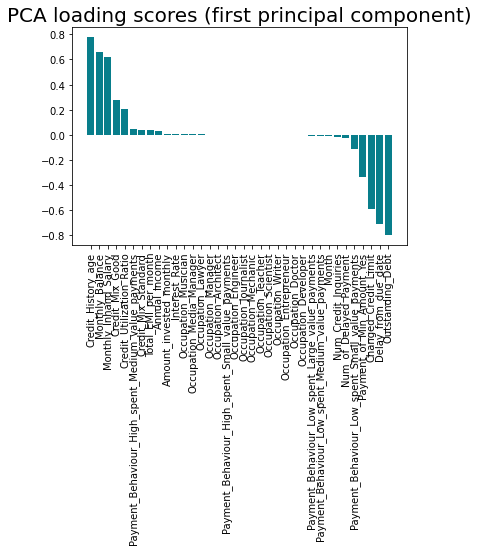

In [50]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

##### - Inputação de Dados

In [51]:
# escolher colunas para inputar e as formas de fazê-lo

### Pré-processamento para modelagem

In [52]:
#Testar dados normalizados e/ou padronizados de formas diferentes (MinMax, Standard, Robust, sem normalizar, etc)

#Encoding (OneHot, Dummy, Label, Ordinary etc)

### Modelagem

In [53]:
# modelos referência (random ou dummy classifier), base (random forest com plot, extratrees, XGBoost, rede neural simples) e ensembles (stacking de xgboost com )